In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/pillbox.csv")
df.head(3)

/var/folders/ph/f7651cvn71dglk2v4rgjpnbw0000gn/T/ipykernel_47358/2048098768.py:1: DtypeWarning: Columns (6,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/pillbox.csv")


,ID,Enabled?,created at,updated at,spp,setid,splsize,pillbox_size,splshape,splshape_text,...,splimage,has_image,epc_match,version_number,laberer_code,application_number,updated,stale,new,Pillbox Value
0,41846,True,2017 Oct 17 05:32:23 PM,2020 Oct 02 05:14:07 PM,471fa2f1-73a0-49be-89f3-d3e2cfdaeca0-0603-5892-0,471fa2f1-73a0-49be-89f3-d3e2cfdaeca0,16,NaN,C48336,CAPSULE,...,NaN,False,NaN,5,NaN,NaN,True,False,False,False
1,8100,True,2017 Oct 17 05:29:56 PM,2020 Oct 02 04:59:28 PM,116e13c1-ac50-400f-880f-5779f0155b96-59779-074-0,116e13c1-ac50-400f-880f-5779f0155b96,10,NaN,C48348,ROUND,...,NaN,False,NaN,4,NaN,NaN,True,False,False,False
2,5258,True,2017 Oct 17 05:29:44 PM,2017 Oct 17 05:29:44 PM,827ce261-307b-4398-8993-333c08e601fe-49884-129-0,827ce261-307b-4398-8993-333c08e601fe,7,NaN,C48346,PENTAGON (5 SIDED),...,498840129,True,NaN,4,NaN,NaN,False,True,False,True


# Filter out columns

In [3]:
df_cleaned = df[['ID', 'splcolor_text', 'splshape_text', 'product_code', 'medicine_name', 'dosage_form', 'splimage', 'splimprint']].copy()
df_cleaned.columns

Index(['ID', 'splcolor_text', 'splshape_text', 'product_code', 'medicine_name',
       'dosage_form', 'splimage', 'splimprint'],
      dtype='object')

# Deduplicate

In [4]:
print(f"\nOriginal df shape: {df_cleaned.shape}")
original_len = len(df_cleaned)
print(f"Total rows: {len(df_cleaned)}")
print(f"Unique images (splimage): {df_cleaned['splimage'].nunique()}")

# Keep the first occurrence of each splimage
df_cleaned = df_cleaned.drop_duplicates(subset=['splimage'], keep='first')
deduplicated_len = len(df_cleaned)

print(f"\nAfter deduplication:")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"Total rows: {len(df_cleaned)}")
print(f"Unique images (splimage): {df_cleaned['splimage'].nunique()}")
print(f"\nRows removed: {original_len - deduplicated_len}")


Original df shape: (83925, 8)
Total rows: 83925
Unique images (splimage): 8693

After deduplication:
Cleaned shape: (8694, 8)
Total rows: 8694
Unique images (splimage): 8693

Rows removed: 75231


# Map image to row

In [5]:
import os

# create a list of image names from pillbox file
image_files = os.listdir('data/pillbox_production_images_full_202008')
df_images = pd.DataFrame({
    'original_name': [f for f in image_files if f.endswith(('.jpg', '.png'))],
    'image_name': [f.replace('.jpg', '').replace('.png', '').upper() for f in image_files if f.endswith(('.jpg', '.png'))]
})
df_images.head(5)

,original_name,image_name
0,8b4a7e47-351f-4f6f-e053-2a95a90a6448.jpg,8B4A7E47-351F-4F6F-E053-2A95A90A6448
1,422910697.jpg,422910697
2,00527-1349-10_53082981.jpg,00527-1349-10_53082981
3,604290239.jpg,604290239
4,65862-0008-99_NLMIMAGE10_B044D816.jpg,65862-0008-99_NLMIMAGE10_B044D816


In [6]:
# perform inner join
df_cleaned = pd.merge(df_cleaned, df_images, how='inner', left_on='splimage', right_on='image_name')
print(f"Rows after inner join: {len(df_cleaned)}")
df_cleaned = df_cleaned.drop(columns='image_name')
df_cleaned.head()

Rows after inner join: 8002


,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,splimprint,original_name
0,5258,GREEN,PENTAGON (5 SIDED),49884-129,Dexamethasone,C42998,498840129,par;129,498840129.jpg
1,20426,YELLOW,CAPSULE,0555-1883,Benzonatate,C25158,005551883,PA83,005551883.jpg
2,34634,BLUE,CAPSULE,62584-975,Diltiazem Hydrochloride,C42916,625840975,R;2577,625840975.jpg
3,29801,YELLOW,OVAL,0228-2855,guanfacine,C42927,00228-2855-11_NLMIMAGE10_0B4085F4,855,00228-2855-11_NLMIMAGE10_0B4085F4.jpg
4,3766,YELLOW;BROWN,CAPSULE,63739-375,Gabapentin,C25158,637390375,R2666,637390375.jpg


# Clean splimprint

In [7]:
# Count number of colors per row (split by ';')
df_cleaned['num_colors'] = df_cleaned['splcolor_text'].str.split(';').str.len()

# Count rows by number of colors
color_distribution = df_cleaned['num_colors'].value_counts().sort_index()

for num_colors, count in color_distribution.items():
    print(f"Rows with {int(num_colors)} color(s): {count}")

print(f"\nTotal rows with color data: {df_cleaned['num_colors'].notna().sum()}")
print(f"Rows with missing color data: {df_cleaned['num_colors'].isna().sum()}")

Rows with 1 color(s): 7356
Rows with 2 color(s): 643
Rows with 3 color(s): 2
Rows with 4 color(s): 1

Total rows with color data: 8002
Rows with missing color data: 0


## Take first colour in the string

In [8]:
df_cleaned['splcolor_text'] = df_cleaned['splcolor_text'].str.split(';').str[0]
df_cleaned.head(3)

,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,splimprint,original_name,num_colors
0,5258,GREEN,PENTAGON (5 SIDED),49884-129,Dexamethasone,C42998,498840129,par;129,498840129.jpg,1
1,20426,YELLOW,CAPSULE,0555-1883,Benzonatate,C25158,005551883,PA83,005551883.jpg,1
2,34634,BLUE,CAPSULE,62584-975,Diltiazem Hydrochloride,C42916,625840975,R;2577,625840975.jpg,1


# Clean splimprint

In [9]:
# Count number of imprint sections per row (split by ';')
df_cleaned['num_imprints'] = df_cleaned['splimprint'].str.split(';').str.len()

# Count rows by number of imprint sections
imprint_distribution = df_cleaned['num_imprints'].value_counts().sort_index()

for num_imprints, count in imprint_distribution.items():
    print(f"Rows with {int(num_imprints)} imprint section(s): {count}")
print(f"Rows with missing imprint data: {df_cleaned['num_imprints'].isna().sum()}")

Rows with 1 imprint section(s): 1463
Rows with 2 imprint section(s): 4781
Rows with 3 imprint section(s): 1250
Rows with 4 imprint section(s): 379
Rows with 5 imprint section(s): 72
Rows with 6 imprint section(s): 15
Rows with 7 imprint section(s): 4
Rows with 9 imprint section(s): 1
Rows with missing imprint data: 37


In [10]:
import re

# Find all non-alphanumeric symbols in splimprint
symbols = {}
for idx, row in df_cleaned.iterrows():
    imprint = str(row['splimprint'])
    if imprint != 'nan':
        non_alnum = re.findall(r'[^A-Za-z0-9]', imprint)
        for sym in set(non_alnum):
            if sym not in symbols:
                symbols[sym] = []
            if len(symbols[sym]) < 5:  # Keep max 5 examples
                symbols[sym].append(imprint)

# Display results
print("Non-alphanumeric symbols found in splimprint:")
print("=" * 60)
for sym, examples in sorted(symbols.items()):
    print(f"\nSymbol: '{sym}'")
    print(f"Examples: {examples[:5]}")

Non-alphanumeric symbols found in splimprint:

Symbol: ' '
Examples: ['WPI;2228 OR PLIVA;517', 'WPI;2229 OR PLIVA;430']

Symbol: '-'
Examples: ['54-980', 'West-ward;248', 'West-ward;939', 'Macrodantin;100;mg;0149-0009', 'APO;QU-40']

Symbol: '.'
Examples: ['Deltasone;2.5', 'ROCALTROL;0.25;ROCHE', 'ROCALTROL;0.5;ROCHE']

Symbol: '/'
Examples: ['U/121;2½', 'IL/3613']

Symbol: ';'
Examples: ['par;129', 'R;2577', 'E;2;5', 'ASPIRIN;44;249', 'AR;788']

Symbol: '½'
Examples: ['U/121;2½']


In [11]:
# Clean splimprint: replace ';', '-', '/' with '_'
df_cleaned['splimprint_clean'] = df_cleaned['splimprint'].str.replace('[;/-]', '_', regex=True)

# Replace ' OR ' with '_'
df_cleaned['splimprint_clean'] = df_cleaned['splimprint_clean'].str.replace(' OR ', '_', regex=False)

# Replace ½ with 1_2
df_cleaned['splimprint_clean'] = df_cleaned['splimprint_clean'].str.replace('½', '1_2', regex=False)

# Replace . with _
df_cleaned['splimprint_clean'] = df_cleaned['splimprint_clean'].str.replace('.', '_', regex=False)

# Convert to upper
df_cleaned['splimprint_clean'] = df_cleaned['splimprint_clean'].str.upper()

In [12]:
# Final check for remaining non-alphanumeric symbols
remaining_symbols = {}
for idx, row in df_cleaned.iterrows():
    imprint = str(row['splimprint_clean'])
    if imprint != 'nan':
        non_alnum = re.findall(r'[^A-Za-z0-9_]', imprint)  # Allow underscore
        for sym in set(non_alnum):
            if sym not in remaining_symbols:
                remaining_symbols[sym] = []
            if len(remaining_symbols[sym]) < 5:
                remaining_symbols[sym].append(imprint)

if remaining_symbols:
    print("Remaining non-alphanumeric symbols (excluding '_'):")
    print("=" * 60)
    for sym, examples in sorted(remaining_symbols.items()):
        print(f"\nSymbol: '{sym}'")
        print(f"Examples: {examples[:5]}")
else:
    print("✓ No remaining symbols! All clean (only A-Z, 0-9, _)")

df_cleaned.head(3)

✓ No remaining symbols! All clean (only A-Z, 0-9, _)


,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,splimprint,original_name,num_colors,num_imprints,splimprint_clean
0,5258,GREEN,PENTAGON (5 SIDED),49884-129,Dexamethasone,C42998,498840129,par;129,498840129.jpg,1,2.0,PAR_129
1,20426,YELLOW,CAPSULE,0555-1883,Benzonatate,C25158,005551883,PA83,005551883.jpg,1,1.0,PA83
2,34634,BLUE,CAPSULE,62584-975,Diltiazem Hydrochloride,C42916,625840975,R;2577,625840975.jpg,1,2.0,R_2577


# Remove Null vales

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8002 non-null   int64  
 1   splcolor_text     8002 non-null   object 
 2   splshape_text     8002 non-null   object 
 3   product_code      8002 non-null   object 
 4   medicine_name     8002 non-null   object 
 5   dosage_form       8002 non-null   object 
 6   splimage          8002 non-null   object 
 7   splimprint        7965 non-null   object 
 8   original_name     8002 non-null   object 
 9   num_colors        8002 non-null   int64  
 10  num_imprints      7965 non-null   float64
 11  splimprint_clean  7965 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 750.3+ KB


In [14]:
df_cleaned = df_cleaned.dropna(subset=['splimprint'])
print(f"Final Row Count: {len(df_cleaned)}")
df_cleaned.drop(columns=['splimprint','num_colors', 'num_imprints'], inplace=True)
df_cleaned.head(3)

Final Row Count: 7965


,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,original_name,splimprint_clean
0,5258,GREEN,PENTAGON (5 SIDED),49884-129,Dexamethasone,C42998,498840129,498840129.jpg,PAR_129
1,20426,YELLOW,CAPSULE,0555-1883,Benzonatate,C25158,005551883,005551883.jpg,PA83
2,34634,BLUE,CAPSULE,62584-975,Diltiazem Hydrochloride,C42916,625840975,625840975.jpg,R_2577


In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7965 entries, 0 to 8001
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                7965 non-null   int64 
 1   splcolor_text     7965 non-null   object
 2   splshape_text     7965 non-null   object
 3   product_code      7965 non-null   object
 4   medicine_name     7965 non-null   object
 5   dosage_form       7965 non-null   object
 6   splimage          7965 non-null   object
 7   original_name     7965 non-null   object
 8   splimprint_clean  7965 non-null   object
dtypes: int64(1), object(8)
memory usage: 622.3+ KB


In [16]:
print(f"\nOriginal df shape: {df_cleaned.shape}")
original_len = len(df_cleaned)
print(f"Total rows: {len(df_cleaned)}")
print(f"Unique images (medicine_name): {df_cleaned['medicine_name'].nunique()}")

# Keep the first occurrence of each splimage
df_cleaned = df_cleaned.drop_duplicates(subset=['splimage'], keep='first')
deduplicated_len = len(df_cleaned)

print(f"\nAfter deduplication:")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"Total rows: {len(df_cleaned)}")
print(f"Unique images (splimage): {df_cleaned['splimage'].nunique()}")
print(f"\nRows removed: {original_len - deduplicated_len}")


Original df shape: (7965, 9)
Total rows: 7965
Unique images (medicine_name): 1773

After deduplication:
Cleaned shape: (7965, 9)
Total rows: 7965
Unique images (splimage): 7965

Rows removed: 0


# Check for Duplicates in medicine_name
There are duplicates but refer to different pills

Total rows: 7965
Unique medicine names: 1773
Duplicate medicine names: 6192

Number of medicine names that appear multiple times: 1158

Top 10 most frequent duplicate medicine names:
Warfarin Sodium: 70 occurrences
Gabapentin: 67 occurrences
Lisinopril: 58 occurrences
Carvedilol: 53 occurrences
Risperidone: 48 occurrences
Simvastatin: 48 occurrences
Metformin Hydrochloride: 48 occurrences
Diltiazem Hydrochloride: 47 occurrences
Olanzapine: 45 occurrences
Propranolol Hydrochloride: 45 occurrences


Showing 5 images for 'Warfarin Sodium' (70 total occurrences):


,medicine_name,splcolor_text,splshape_text,splimprint_clean,original_name
137,Warfarin Sodium,WHITE,OVAL,WAR_10,68382-0059-01_311298D4.jpg
150,Warfarin Sodium,PURPLE,ROUND,IG_W_2,762820328.jpg
389,Warfarin Sodium,YELLOW,OVAL,7_1_2_WARFARIN_TARO,516724034.jpg
585,Warfarin Sodium,WHITE,ROUND,IG_W_10,762820335.jpg
761,Warfarin Sodium,ORANGE,OVAL,TV_5_1721,00093172101.jpg


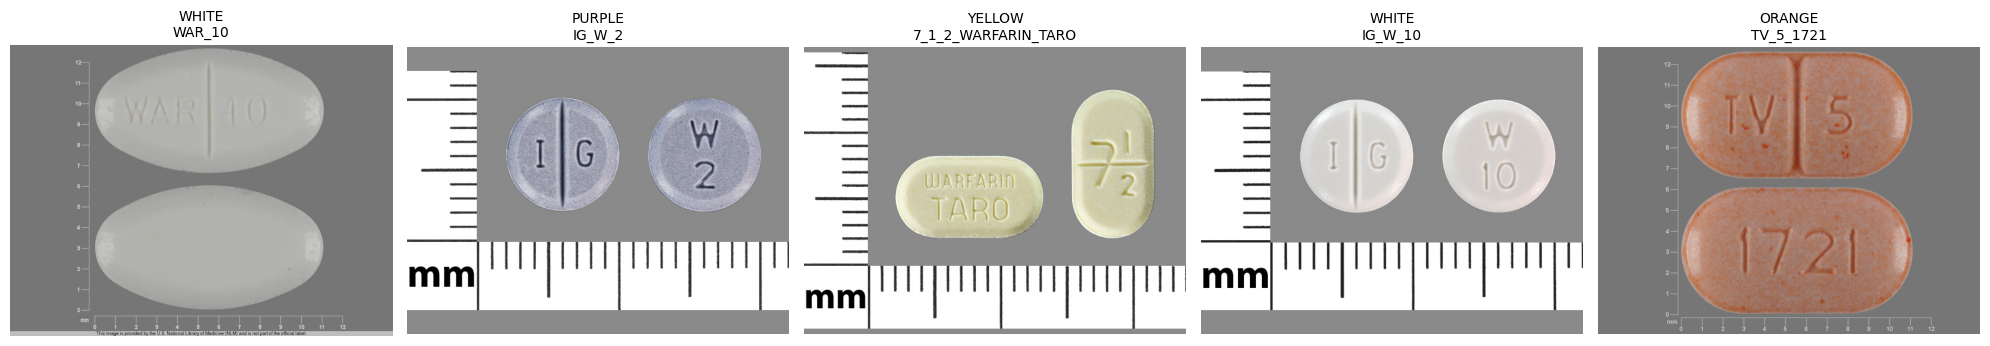

In [17]:
# Check for duplicates in medicine_name column
print(f"Total rows: {len(df_cleaned)}")
print(f"Unique medicine names: {df_cleaned['medicine_name'].nunique()}")
print(f"Duplicate medicine names: {len(df_cleaned) - df_cleaned['medicine_name'].nunique()}")

# Find medicine names that appear more than once
duplicate_medicine_names = df_cleaned['medicine_name'].value_counts()
duplicate_medicine_names = duplicate_medicine_names[duplicate_medicine_names > 1]

print(f"\nNumber of medicine names that appear multiple times: {len(duplicate_medicine_names)}")
print(f"\nTop 10 most frequent duplicate medicine names:")
print("=" * 80)
for medicine_name, count in duplicate_medicine_names.head(10).items():
    print(f"{medicine_name}: {count} occurrences")

# Show example rows for Warfarin Sodium
medicine_to_display = 'Warfarin Sodium'
warfarin_rows = df_cleaned[df_cleaned['medicine_name'] == medicine_to_display]

if len(warfarin_rows) > 0:
    print(f"\n\nShowing {min(5, len(warfarin_rows))} images for '{medicine_to_display}' ({len(warfarin_rows)} total occurrences):")
    print("=" * 80)

    # Display table with details
    display(warfarin_rows[['medicine_name', 'splcolor_text', 'splshape_text', 'splimprint_clean', 'original_name']].head(5))

    # Display the actual images
    from PIL import Image
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for idx, (_, row) in enumerate(warfarin_rows.head(5).iterrows()):
        img_path = f"data/pillbox_production_images_full_202008/{row['original_name']}"
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"{row['splcolor_text']}\n{row['splimprint_clean']}", fontsize=10)
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error loading\n{row['original_name']}",
                          ha='center', va='center', fontsize=8)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"\nNo rows found for '{medicine_to_display}'")

# Split the Data

## Data Split Strategy

**Total: 7,965 images**

### Split Breakdown:
- **Final Test Set**: 796 images (10%) - completely held out until final evaluation
- **Development Set**: 7,169 images (90%)
  - **Initial hand-label batch**: 500 images (for initial YOLO training)
  - **ML-assisted batch**: 1,800 images (YOLO predictions → review/correct)
  - **Combined hand-labeled**: 2,300 images total (for YOLO + ResNet training)
  - **RNN training**: All 7,169 images (using YOLO+ResNet predictions)

### Active Learning Workflow:
1. Hand-label 500 images (all unique characters covered ✓)
2. Train YOLO on 500 images
3. Use YOLO to predict on 1,800 images
4. Import predictions into LabelStudio, review & correct
5. Final: 500 + 1,800 = 2,300 labeled images for YOLO + ResNet
6. Train RNN on all 7,169 dev images

**Key constraint**: Both 500 and 2,300 batches include ALL unique characters from splimprint_clean

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Extract all unique characters from splimprint_clean
all_chars = set(''.join(df_cleaned['splimprint_clean'].values))
print(f"Total unique characters: {len(all_chars)}")
print(f"Characters: {sorted(all_chars)}\n")

# Split into Final Test (10%) and Development (90%)
df_dev, df_test = train_test_split(
    df_cleaned,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

print(f"Final Test Set: {len(df_test)} images")
print(f"Development Set: {len(df_dev)} images\n")


def sample_with_char_coverage(df, n_samples, all_required_chars, random_state=42):
    """Sample n_samples ensuring all unique characters are covered."""
    sampled_indices = []
    covered_chars = set()
    remaining_df = df.copy()
    
    # Calculate character frequency
    char_freq = {char: remaining_df['splimprint_clean'].str.contains(char, regex=False).sum() 
                 for char in all_required_chars}
    
    # Phase 1: Cover all characters (prioritize rare ones)
    for char, _ in sorted(char_freq.items(), key=lambda x: x[1]):
        if char in covered_chars:
            continue
        
        candidates = remaining_df[remaining_df['splimprint_clean'].str.contains(char, regex=False)].copy()
        
        if len(candidates) > 0:
            # Prefer images with multiple uncovered characters
            candidates['uncovered_count'] = candidates['splimprint_clean'].apply(
                lambda x: len(set(x) - covered_chars)
            )
            best = candidates.nlargest(1, 'uncovered_count')
            
            idx = best.index[0]
            sampled_indices.append(idx)
            covered_chars.update(set(best.iloc[0]['splimprint_clean']))
            remaining_df = remaining_df.drop(idx)
    
    print(f"Phase 1: {len(sampled_indices)} images → covered {len(covered_chars)}/{len(all_required_chars)} characters")
    
    # Phase 2: Random sampling to reach n_samples
    remaining_needed = n_samples - len(sampled_indices)
    if remaining_needed > 0:
        additional = remaining_df.sample(n=remaining_needed, random_state=random_state)
        sampled_indices.extend(additional.index.tolist())
        print(f"Phase 2: +{remaining_needed} random samples")
    
    print(f"Total: {len(sampled_indices)} samples\n")
    return df.loc[sampled_indices]


# Sample 2,300 hand-labeled images
df_hand_labeled_2300 = sample_with_char_coverage(df_dev, 2300, all_chars, RANDOM_STATE)

# Sample 500 initial batch from the 2,300 (ensuring all characters covered)
df_hand_labeled_500 = sample_with_char_coverage(df_hand_labeled_2300, 500, all_chars, RANDOM_STATE)

# Remaining 1,800 for ML-assisted labeling
df_ml_assisted_1800 = df_hand_labeled_2300.drop(df_hand_labeled_500.index)

# Verification
hand_500_chars = set(''.join(df_hand_labeled_500['splimprint_clean'].values))
hand_2300_chars = set(''.join(df_hand_labeled_2300['splimprint_clean'].values))

print("=" * 60)
print("VERIFICATION")
print("=" * 60)
print(f"✓ Initial hand-label batch: {len(df_hand_labeled_500)} images")
print(f"✓ All characters in 500: {len(hand_500_chars) == len(all_chars)} ({len(hand_500_chars)}/{len(all_chars)})")
print(f"✓ ML-assisted batch: {len(df_ml_assisted_1800)} images")
print(f"✓ Total hand-labeled: {len(df_hand_labeled_2300)} images")
print(f"✓ All characters in 2300: {len(hand_2300_chars) == len(all_chars)} ({len(hand_2300_chars)}/{len(all_chars)})")
print("=" * 60)

Total unique characters: 37
Characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']

Final Test Set: 797 images
Development Set: 7168 images

Phase 1: 5 images → covered 37/37 characters
Phase 2: +2295 random samples
Total: 2300 samples

Phase 1: 5 images → covered 37/37 characters
Phase 2: +495 random samples
Total: 500 samples

VERIFICATION
✓ Initial hand-label batch: 500 images
✓ All characters in 500: True (37/37)
✓ ML-assisted batch: 1800 images
✓ Total hand-labeled: 2300 images
✓ All characters in 2300: True (37/37)


## Save the Splits

In [19]:
# Create splits directory
import os
os.makedirs('data/splits', exist_ok=True)

# Save all splits as CSV
df_cleaned.to_csv('data/splits/pillbox_full.csv', index=False)
df_test.to_csv('data/splits/final_test.csv', index=False)
df_dev.to_csv('data/splits/development.csv', index=False)
df_hand_labeled_2300.to_csv('data/splits/hand_labeled_2300.csv', index=False)
df_hand_labeled_500.to_csv('data/splits/hand_labeled_500_initial.csv', index=False)
df_ml_assisted_1800.to_csv('data/splits/ml_assisted_1800.csv', index=False)

print("Saved data splits:")
print(f"  - final_test.csv ({len(df_test)} images)")
print(f"  - development.csv ({len(df_dev)} images)")
print(f"  - hand_labeled_2300.csv ({len(df_hand_labeled_2300)} images)")
print(f"  - hand_labeled_500_initial.csv ({len(df_hand_labeled_500)} images)")
print(f"  - ml_assisted_1800.csv ({len(df_ml_assisted_1800)} images)")
print(f"\nActive Learning Workflow:")
print(f"  1. Hand-label 500 initial images")
print(f"  2. Train YOLO on 500 images")
print(f"  3. Predict on 1,800 images")
print(f"  4. Review & correct predictions")
print(f"  5. Final: 500 + 1,800 = 2,300 total")

Saved data splits:
  - final_test.csv (797 images)
  - development.csv (7168 images)
  - hand_labeled_2300.csv (2300 images)
  - hand_labeled_500_initial.csv (500 images)
  - ml_assisted_1800.csv (1800 images)

Active Learning Workflow:
  1. Hand-label 500 initial images
  2. Train YOLO on 500 images
  3. Predict on 1,800 images
  4. Review & correct predictions
  5. Final: 500 + 1,800 = 2,300 total
